# Word2Vec Assignment

<b>Name:</b> Abhinav Lugun <b>Student Id:</b> st122322

## Introduction

In this assignment, cbow was implmented and comparison between skipgram and its negative sampling version was made in terms of training time. Also, a window size of 2 was used to get 2 context neigbhors of center word. Samples of text were selected from Wikipedia on 'badminton' and 'python programming language' as a corpus. One preprocessing step was carried out to remove the citations (e.g. [1], [2]) from the corpus since Wikipedia contains many of it.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Skipgrams and Negative Sampling Implementation

## 1) Load Data

https://en.wikipedia.org/wiki/Python_(programming_language)

https://en.wikipedia.org/wiki/Badminton

In [2]:
import dataset

In [3]:
dataset.badminton

'\nBadminton is a racquet sport played using racquets to hit a shuttlecock across a net. Although it may be played with larger teams, the most common forms of the game are "singles" (with one player per side) and "doubles" (with two players per side). Badminton is often played as a casual outdoor activity in a yard or on a beach; formal games are played on a rectangular indoor court. Points are scored by striking the shuttlecock with the racquet and landing it within the opposing side\'s half of the court.\n\nEach side may only strike the shuttlecock once before it passes over the net. Play ends once the shuttlecock has struck the floor or if a fault has been called by the umpire, service judge, or (in their absence) the opposing side.[1]\n\nThe shuttlecock is a feathered or (in informal matches) plastic projectile which flies differently from the balls used in many other sports. In particular, the feathers create much higher drag, causing the shuttlecock to decelerate more rapidly. Sh

In [4]:
dataset.python

'\nPython is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.[33]\n\nPython is dynamically-typed and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.[34][35]\n\nGuido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released it in 1991 as Python 0.9.0.[36] Python 2.0 was released in 2000 and introduced new features such as list comprehensions, cycle-detecting garbage collection, reference counting, and Unicode support. Python 3.0, released in 2008, was a major revision not completely backward-compatible with earlier versions. Python 2.7.18, released in 2020, was the last release of Python 2.[37]\n\nPython consistently ranks as one 

## 2) Prepare Data for Training

<b>Steps:</b>
<ol>
    <li>Combine documents</li>
    <li>Remove citation references</li>
    <li>Tokenization</li>
    <li>Remove citation references</li>
    <li>Numericalization</li>
    <li>Creating (context word, outside word) tuples</li>
</ol>

### 2.1) Combine documents

In [5]:
import copy

In [6]:
corpus = copy.copy(dataset.badminton)

In [7]:
corpus += dataset.python

In [8]:
assert len(dataset.badminton) + len(dataset.python) == len(corpus)

### 2.2) Remove citation references

https://stackoverflow.com/questions/67605758/how-to-match-and-remove-wikipedia-refences-with-python-and-re

In [9]:
import re

In [10]:
modified_corpus = re.sub("\[[0-9]+\]", '', corpus)

In [11]:
modified_corpus[:1000]

'\nBadminton is a racquet sport played using racquets to hit a shuttlecock across a net. Although it may be played with larger teams, the most common forms of the game are "singles" (with one player per side) and "doubles" (with two players per side). Badminton is often played as a casual outdoor activity in a yard or on a beach; formal games are played on a rectangular indoor court. Points are scored by striking the shuttlecock with the racquet and landing it within the opposing side\'s half of the court.\n\nEach side may only strike the shuttlecock once before it passes over the net. Play ends once the shuttlecock has struck the floor or if a fault has been called by the umpire, service judge, or (in their absence) the opposing side.\n\nThe shuttlecock is a feathered or (in informal matches) plastic projectile which flies differently from the balls used in many other sports. In particular, the feathers create much higher drag, causing the shuttlecock to decelerate more rapidly. Shutt

### 2.3) Tokenization

In [12]:
import spacy

In [13]:
nlp = spacy.load("en_core_web_sm")

In [14]:
corpus_tokenized   = []
sentence_tokenized = []

for token in nlp(modified_corpus):
    if token.text == '\n' or token.text == '.':
        if len(sentence_tokenized) > 0:
            corpus_tokenized.append(sentence_tokenized)
            sentence_tokenized = []
        continue
    sentence_tokenized.append(token.text.lower())

In [15]:
print("-----> Tokenization of four sample sentences:")
count = 0
for sentence in corpus_tokenized:
    print("Sentence", count + 1)
    print(sentence, end="\n\n") 
    count +=1
    if count == 4:
        break

-----> Tokenization of four sample sentences:
Sentence 1
['badminton', 'is', 'a', 'racquet', 'sport', 'played', 'using', 'racquets', 'to', 'hit', 'a', 'shuttlecock', 'across', 'a', 'net']

Sentence 2
['although', 'it', 'may', 'be', 'played', 'with', 'larger', 'teams', ',', 'the', 'most', 'common', 'forms', 'of', 'the', 'game', 'are', '"', 'singles', '"', '(', 'with', 'one', 'player', 'per', 'side', ')', 'and', '"', 'doubles', '"', '(', 'with', 'two', 'players', 'per', 'side', ')']

Sentence 3
['badminton', 'is', 'often', 'played', 'as', 'a', 'casual', 'outdoor', 'activity', 'in', 'a', 'yard', 'or', 'on', 'a', 'beach', ';', 'formal', 'games', 'are', 'played', 'on', 'a', 'rectangular', 'indoor', 'court']

Sentence 4
['points', 'are', 'scored', 'by', 'striking', 'the', 'shuttlecock', 'with', 'the', 'racquet', 'and', 'landing', 'it', 'within', 'the', 'opposing', 'side', "'s", 'half', 'of', 'the', 'court']



### 2.4) Create vocabulary

In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

In [17]:
print("Vocabulary size:", len(vocabs))

Vocabulary size: 603


In [18]:
print(vocabs[:20])

['produced', 'drag', 'indonesia', 'outdoor', 'setl', 'general', 'good', '2018', 'interchangeably', 'years', 'denmark', 'often', 'dominated', '–', 'force', 'four', 'modern', 'fixes', 'stable', 'fault']


### 2.5) Numericalization

In [19]:
word2index = {v: idx for idx, v in enumerate(vocabs)}

In [20]:
### Including UNK for words not in vocab
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

In [21]:
index2word = {v:k for k, v in word2index.items()}

In [22]:
word2index["which"]

56

In [23]:
index2word[29]

'amoeba'

### 2.6) Creating (context word, outside word) tuples

In [24]:
window_size = 2

In [25]:
skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ['it', 'takes', 'place', 'on', 'a', 'hard', 'table', 'divided', 'by', 'a', 'net']
    for i in range(window_size, len(sent) - window_size):
        center_word = word2index[sent[i]]
        outside_words = []
        for j in range(1, window_size + 1):
            outside_words.append(word2index[sent[i-j]])
            outside_words.append(word2index[sent[i+j]])
            
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:15]

[[494, 573],
 [494, 376],
 [494, 87],
 [494, 416],
 [376, 494],
 [376, 416],
 [376, 573],
 [376, 506],
 [416, 376],
 [416, 506],
 [416, 494],
 [416, 287],
 [506, 416],
 [506, 287],
 [506, 376]]

In [26]:
print("Total samples:", len(skipgrams))

Total samples: 5160


### 2.7) Creating random_batch function

In [27]:
def random_batch(batch_size, corpus, skip_grams):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

<b>Test Function</b>

In [28]:
input, label = random_batch(10, corpus_tokenized, skipgrams)

print("Input sample:", input)
print(f"Input shape: {input.shape}", end="\n\n")
print(f"Label sample: {label=}")
print("Label shape:", label.shape)

Input sample: [[432]
 [567]
 [569]
 [416]
 [262]
 [358]
 [318]
 [161]
 [434]
 [ 99]]
Input shape: (10, 1)

Label sample: label=array([[422],
       [143],
       [581],
       [376],
       [ 37],
       [ 99],
       [289],
       [387],
       [229],
       [ 56]])
Label shape: (10, 1)


## 3) Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [29]:
z = 0.001

In [30]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))

In [31]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

1554

In [32]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)

## 4) Helper functions for skipgram with negative sampling

In [33]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [34]:
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

<b>Test Model</b>

In [35]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size, corpus_tokenized, skipgrams)

input_batch, label_batch

(array([[49],
        [50]]),
 array([[591],
        [444]]))

In [36]:
input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [37]:
num_neg = 5  #in the real code, we gonna use 10 (like in the paper)
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [38]:
neg_samples.shape

torch.Size([2, 5])

## 5) Model

### 5.1) Skipgram

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [39]:
voc_size = len(vocabs)
voc_size

604

In [40]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vector for outside words
#v_c - vector for center word
#u_w - vectors of all vocabs

class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [41]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 604])

<b>Test Model</b>

In [42]:
# Sample input and label

In [43]:
input, label = random_batch(batch_size, corpus_tokenized, skipgrams)

In [44]:
input, label

(array([[564],
        [506]]),
 array([[179],
        [287]]))

In [45]:
#### Test model

In [46]:
emb_size = 2
model = Skipgram(voc_size, emb_size)

In [47]:
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label) 

In [48]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [49]:
loss

tensor(7.4216, grad_fn=<NegBackward0>)

### 5.2) Skipgram with negative sampling

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [50]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

<b>Test Model</b>

In [51]:
input, label = random_batch(batch_size, corpus_tokenized, skipgrams)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [52]:
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [53]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [54]:
input_tensor.shape, label_tensor.shape#, neg_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [55]:
loss = model(input_tensor, label_tensor, neg_tensor)

In [56]:
loss

tensor(3.1567, grad_fn=<NegBackward0>)

## 6) Training

In [57]:
import time

In [58]:
num_epochs = 10000

### 6.1) Skipgram

In [59]:
model1    = Skipgram(voc_size, emb_size)
emb_size  = 2
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [60]:
train_start_time = time.time()

#for epoch
for epoch in range(num_epochs):
    start_time = time.time()
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized, skipgrams)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model1(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    total_time = time.time() - start_time
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {total_time}")
        
total_training_time = time.time() - train_start_time
print("Total trainig time:", total_training_time)

Epoch 1000 | Loss: 8.867957 | Time: 0.0
Epoch 2000 | Loss: 8.584539 | Time: 0.0010001659393310547
Epoch 3000 | Loss: 6.258250 | Time: 0.0
Epoch 4000 | Loss: 6.847474 | Time: 0.0
Epoch 5000 | Loss: 8.206119 | Time: 0.004718780517578125
Epoch 6000 | Loss: 5.778250 | Time: 0.0
Epoch 7000 | Loss: 6.458988 | Time: 0.0
Epoch 8000 | Loss: 8.775762 | Time: 0.0015561580657958984
Epoch 9000 | Loss: 9.277250 | Time: 0.0010020732879638672
Epoch 10000 | Loss: 8.042551 | Time: 0.0020003318786621094
Total trainig time: 13.411455392837524


### 6.2) Skipgram with negative sampling

In [61]:
emb_size  = 2
model2 = SkipgramNeg(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [62]:
train_start_time = time.time()

#for epoch
for epoch in range(num_epochs):
    start_time = time.time()
    
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus, skipgrams)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    total_time = time.time() - start_time
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {total_time}")
        
total_training_time = time.time() - train_start_time
print("Total trainig time:", total_training_time)

Epoch 1000 | Loss: 0.984130 | Time: 0.0019958019256591797
Epoch 2000 | Loss: 1.238947 | Time: 0.0013623237609863281
Epoch 3000 | Loss: 1.162189 | Time: 0.0010001659393310547
Epoch 4000 | Loss: 2.395325 | Time: 0.001117706298828125
Epoch 5000 | Loss: 1.853068 | Time: 0.0
Epoch 6000 | Loss: 1.660788 | Time: 0.0009999275207519531
Epoch 7000 | Loss: 0.984101 | Time: 0.0010967254638671875
Epoch 8000 | Loss: 0.931554 | Time: 0.0012738704681396484
Epoch 9000 | Loss: 1.371281 | Time: 0.0011317729949951172
Epoch 10000 | Loss: 1.417226 | Time: 0.0011339187622070312
Total trainig time: 12.144208192825317


### 7) Visualizing Embedding

In [63]:
def get_embed(model, word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

### 7.1) Skipgram

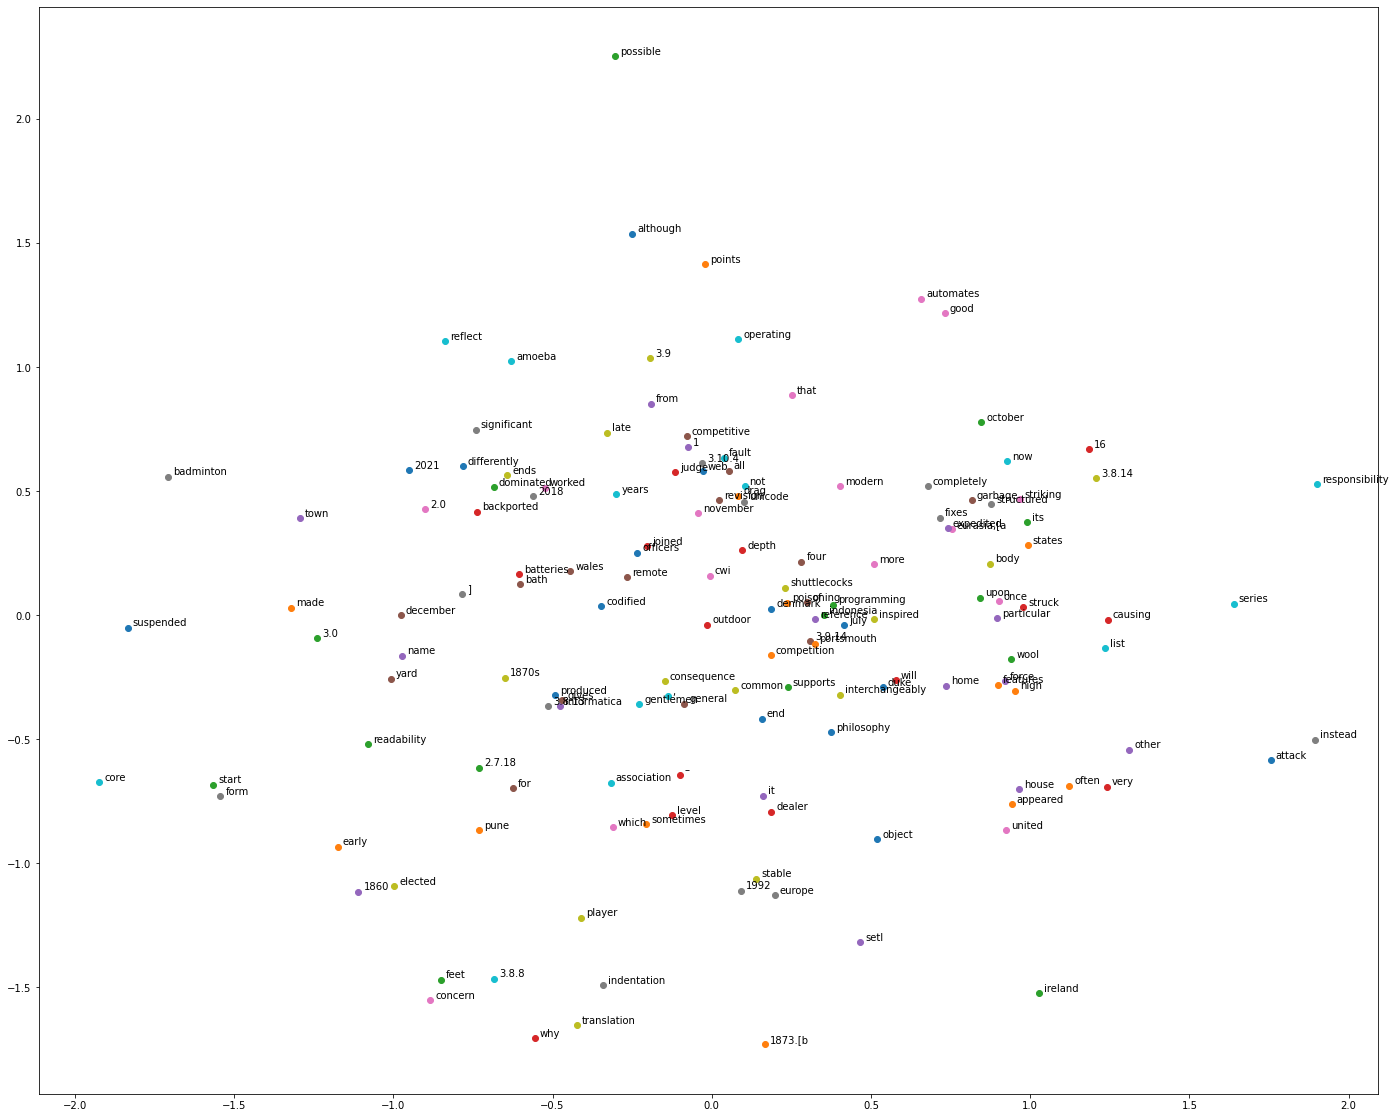

In [64]:
plt.figure(figsize=(24,20))
for i, word in enumerate(vocabs[:150]): #loop each unique vocab
    x, y = get_embed(model1, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [65]:
sampleWords = ['python', 'badminton', 'features', 'code', 'racquet', 'sport', 'language', 'net']

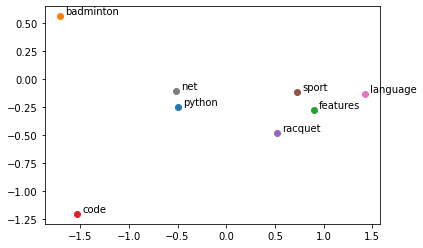

In [66]:
for word in sampleWords:
    x, y = get_embed(model1, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

### 7.2) Skipgram with negative sampling

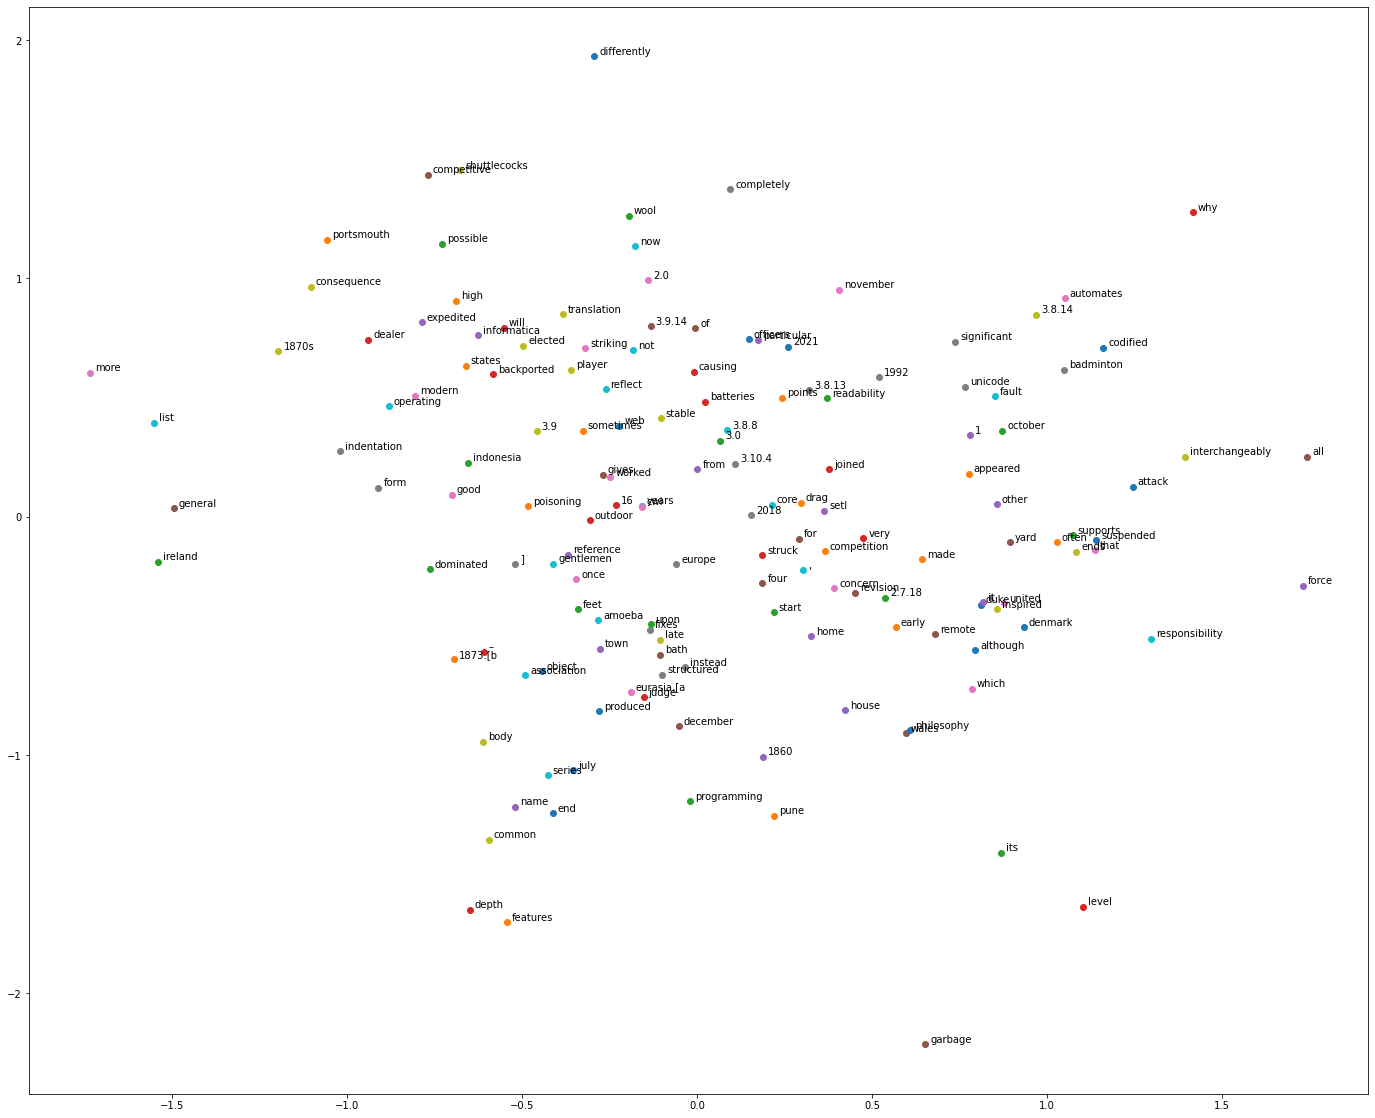

In [67]:
plt.figure(figsize=(24,20))
for i, word in enumerate(vocabs[:150]): #loop each unique vocab
    x, y = get_embed(model2, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

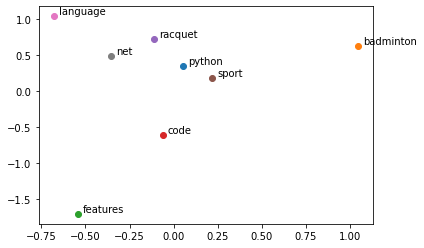

In [68]:
for word in sampleWords:
    x, y = get_embed(model2, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

## 8) Observation

Both skipgram and its negative sampling version took almost same amount of time to train the embeddings. However, it is assumed that the negative sampling should train faster due to being more optimized. In this case, because the training sample was not very big, the difference is not great. So, it could also be unreliable because on some runs, skipgram is shown to train faster.

Because the vobaculary for is quite big, very selected words specific to the topics, badminton and python programming language, were used for smaller version of embedding visualization. From the plots of both skip-gram and its negative sampling version, the result was not quite expected as some words are shown to be very similar than others despite being less similar. Maybe due to the limitation of the corpus, the models couldn't learn the embeddings properly based on word similarity.

# CBOW Implementation

## 1) Preparing data for training

In [69]:
skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ['it', 'takes', 'place', 'on', 'a', 'hard', 'table', 'divided', 'by', 'a', 'net']
    for i in range(window_size, len(sent) - window_size):
        center_word = word2index[sent[i]]
        outside_words = []
        for j in range(1, window_size + 1):
            outside_words.append(word2index[sent[i-j]])
            outside_words.append(word2index[sent[i+j]])
            
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:15]

[[494, 573],
 [494, 376],
 [494, 87],
 [494, 416],
 [376, 494],
 [376, 416],
 [376, 573],
 [376, 506],
 [416, 376],
 [416, 506],
 [416, 494],
 [416, 287],
 [506, 416],
 [506, 287],
 [506, 376]]

In [70]:
window_size = 2

In [71]:
skipgrams_CBOW = []

#for each corpus
for sent in corpus_tokenized:
    for i in range(window_size, len(sent) - window_size):
        center_word   = sent[i]
        outside_words = []
        
        low  = i - window_size
        high = i + window_size
        for j in range(low, high + 1):
            if j == i:
                continue
            outside_words.append(sent[j])
        skipgrams_CBOW.append([center_word, outside_words])

In [72]:
skipgrams_CBOW[:15]

[['a', ['badminton', 'is', 'racquet', 'sport']],
 ['racquet', ['is', 'a', 'sport', 'played']],
 ['sport', ['a', 'racquet', 'played', 'using']],
 ['played', ['racquet', 'sport', 'using', 'racquets']],
 ['using', ['sport', 'played', 'racquets', 'to']],
 ['racquets', ['played', 'using', 'to', 'hit']],
 ['to', ['using', 'racquets', 'hit', 'a']],
 ['hit', ['racquets', 'to', 'a', 'shuttlecock']],
 ['a', ['to', 'hit', 'shuttlecock', 'across']],
 ['shuttlecock', ['hit', 'a', 'across', 'a']],
 ['across', ['a', 'shuttlecock', 'a', 'net']],
 ['may', ['although', 'it', 'be', 'played']],
 ['be', ['it', 'may', 'played', 'with']],
 ['played', ['may', 'be', 'with', 'larger']],
 ['with', ['be', 'played', 'larger', 'teams']]]

In [73]:
cbow = []

#for each corpus
for sent in corpus_tokenized:
    for i in range(window_size, len(sent) - window_size):
        center_word   = word2index[sent[i]]
        outside_words = []
        
        low  = i - window_size
        high = i + window_size
        for j in range(low, high + 1):
            if j == i:
                continue
            outside_words.append(word2index[sent[j]])
        cbow.append([center_word, outside_words])

In [74]:
cbow[:15]

[[494, [87, 573, 376, 416]],
 [376, [573, 494, 416, 506]],
 [416, [494, 376, 506, 287]],
 [506, [376, 416, 287, 341]],
 [287, [416, 506, 341, 581]],
 [341, [506, 287, 581, 592]],
 [581, [287, 341, 592, 494]],
 [592, [341, 581, 494, 362]],
 [494, [581, 592, 362, 553]],
 [362, [592, 494, 553, 494]],
 [553, [494, 362, 494, 371]],
 [215, [20, 34, 412, 506]],
 [412, [34, 215, 506, 473]],
 [506, [215, 412, 473, 493]],
 [473, [412, 506, 493, 249]]]

In [75]:
cbow[0][1]

[87, 573, 376, 416]

In [76]:
def random_batch_cbow(batch_size, corpus, cbow):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(cbow)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([cbow[i][0]])  # target, e.g., 2
        random_labels.append([cbow[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels).squeeze()

In [77]:
random_batch_cbow(2, corpus, cbow)[1]

array([[594, 362,  63, 594],
       [420,  10, 594, 466]])

## 2) Model

http://cs224d.stanford.edu/lecture_notes/notes1.pdf

<img src="figures/mean-matrix.png">

<img src="figures/CBOW loss function.png">

In [78]:
#the model will accept three vectors - u_c, u_j, v_mean
#u_c - vector for center word from the output word matrix
#u_j - vectors for all vocab from the output word matrix
#v_mean - mean of the vectors of context words from the input word matrix 

class CBOW(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.emb_size = emb_size
        self.input_word  = nn.Embedding(voc_size, emb_size) #v
        self.output_word = nn.Embedding(voc_size, emb_size) #u
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word: (batch_size, 1)
        #context_words: (batch_size, window_size * 2)
        #all_vocabs: (batch_size, voc_size)
        batch_size = center_word.shape[0]
        
        #convert them into embedding
        center_word_embed  = self.output_word(center_word)   #(batch_size, 1, emb_size)
        outside_word_embed = self.input_word(outside_word)   #(batch_size, window_size * 2, emb_size)
        all_vocabs_embed   = self.output_word(all_vocabs)    #(batch_size, voc_size, emb_size)        
        
        # mean of input word embeddings
        v_mean = torch.sum(outside_word_embed, 1) / len(outside_word) #(batch_size, emb_size)
        
        ucv = center_word_embed.bmm(v_mean.reshape(batch_size, 1, self.emb_size).transpose(1, 2)).squeeze()
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ==> (batch_size, 1)
        
        ujv = all_vocabs_embed.bmm(v_mean.reshape(batch_size, 1, self.emb_size).transpose(1, 2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size)
        
        ujv_log_exp = torch.log(torch.exp(ujv))
        # (batch_size, voc_size) -> (batch_size,)
        
        loss_fn = - ucv + torch.sum(ujv_log_exp, 1)
        # - (batch_size, 1) + (batch_size, 1) = (batch_size, 1)
        
        return torch.mean(loss_fn) # scaler for back-propagation

<b>Test Model</b>

In [79]:
model = CBOW(voc_size, emb_size=2)

In [80]:
input, label = random_batch_cbow(2, corpus, cbow)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 4]))

In [81]:
input_tensor[0], label_tensor[0]

(tensor([99]), tensor([586, 402, 309, 531]))

In [82]:
model(input_tensor, label_tensor, all_vocabs)

tensor(-6.3495, grad_fn=<MeanBackward0>)

## 3) Training

In [83]:
emb_size = 2
model3 = SkipgramNeg(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [84]:
train_start_time = time.time()

#for epoch
for epoch in range(num_epochs):
    start_time = time.time()
    #get random batch
    input_batch, label_batch = random_batch_cbow(batch_size, corpus_tokenized, cbow)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    #loss = model
    loss = model3(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    total_time = time.time() - start_time
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {total_time}")
        
total_training_time = time.time() - train_start_time
print("Total trainig time:", total_training_time)

Epoch 1000 | Loss: 12.365419 | Time: 0.001058816909790039
Epoch 2000 | Loss: 1.067487 | Time: 0.0010561943054199219
Epoch 3000 | Loss: 6.541723 | Time: 0.0
Epoch 4000 | Loss: 0.986264 | Time: 0.0009999275207519531
Epoch 5000 | Loss: 21.547800 | Time: 0.0010001659393310547
Epoch 6000 | Loss: 1.901727 | Time: 0.0010004043579101562
Epoch 7000 | Loss: 5.252507 | Time: 0.0009984970092773438
Epoch 8000 | Loss: 4.570256 | Time: 0.0
Epoch 9000 | Loss: 1.691081 | Time: 0.00099945068359375
Epoch 10000 | Loss: 0.688732 | Time: 0.0010001659393310547
Total trainig time: 8.010570287704468


## 4) Visualizing Embedding

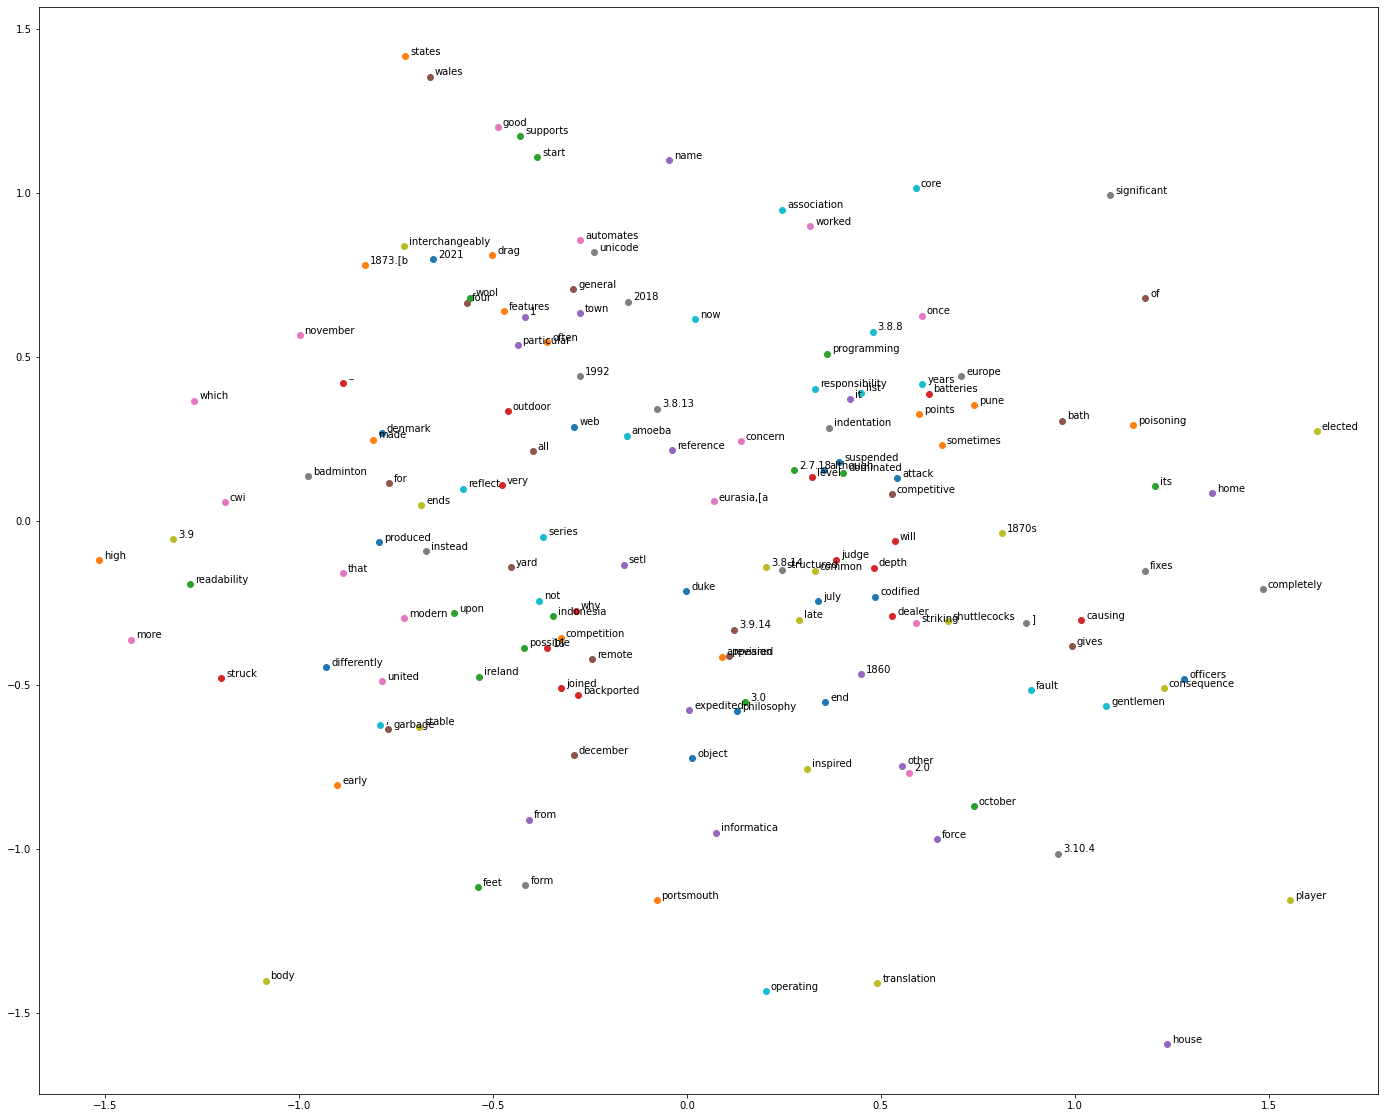

In [85]:
plt.figure(figsize=(24,20))
for i, word in enumerate(vocabs[:150]): #loop each unique vocab
    x, y = get_embed(model3, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

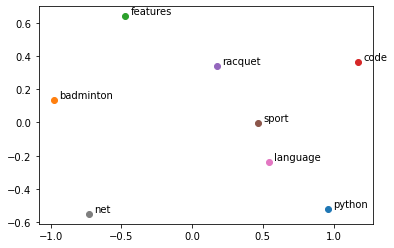

In [86]:
for word in sampleWords:
    x, y = get_embed(model3, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

## 5) Observation

As expected, CBOW trained much faster than skip-gram and its negative sampling version. It shares the problem of not learning embeddings properly.  

## Future Improvement

For future improve, better preprocessing of the corpus could be carried out for the embeddins of the words to be learned more properly. Some of these pre-processing could be filtering out unneccary words (e.g. 'the', 'as', ',' and '.') and stemming could be performed to reduce words to its root.